# Pass success probability model

This notebook will elaborately showcase the occurence of a physics based pass success probability model. Note that the data used for this notebook is not publicaly availabe, but I try to be as elaborate as possible to showcase all the details and assumptions made.

For this model I choose a physics based model, because it is easiest to interpretet and is generalises really good to unforseen situations. Earlier researchers have provided some physics based models ([Spearman et al.](https://www.researchgate.net/publication/315166647_Physics-Based_Modeling_of_Pass_Probabilities_in_Soccer), [Buldu et al.](http://statsbomb.com/wp-content/uploads/2021/11/Javier-M-Buldu.pdf), [Everett et al.](https://www.youtube.com/watch?v=sGGyi56Gx2Q). This model will use some ideas of all these earlier provided models.

Physics based models focus on modelling player and ball trajectories, and use these to create a probability of an interception or a successful pass. For that, we have to make some assumptions about the ball velocity over time, the player velocity over time and the player acceleration, and than relate them to the real pass. Let's start by substentiate these assumptions.

## Loading the data

First we will create a function to loop over the data, obtain 5000 passes. This will help us later on to test our assumptions and the final model.

In [1]:
%matplotlib inline

import math
import os

from scipy.optimize import curve_fit
import scipy.special as sp
from sklearn.metrics import accuracy_score, brier_score_loss, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import random

from databallpy import get_saved_match
from databallpy.visualize import plot_soccer_pitch
from databallpy.features.angle import get_smallest_angle


def create_bins_plot(x_data:np.ndarray, y_data:np.ndarray, n_bins=10, label=None):
    """
    Create a bar plot with bins for grouped data points.

    Args:
        x_data (array-like): Array of x-axis data points.
        y_data (array-like): Array of y-axis data points.
        n_bins (int, optional): Number of bins to divide the x-axis range into. Defaults to 10.
        label (str, optional): Label for the data series. Defaults to None.

    Returns:
        fig, ax: Matplotlib Figure and Axes objects.

    Notes:
        - The function creates a bar plot where the x-axis is divided into 'n_bins' bins.
        - Each bin contains the mean value of 'y_data' corresponding to the x-axis values falling within that bin,
          along with error bars representing the standard deviation.
        - The function returns the Matplotlib Figure and Axes objects for further customization or display.
    """
    fig, ax = plt.subplots()
    x_data = np.array(x_data)
    y_data = np.array(y_data)
    bins = np.linspace(np.min(x_data), np.max(x_data), num=n_bins + 1)
    bin_diff = bins[1] - bins[0]
    bin_indices = np.digitize(x_data, bins)
    mean_y = [y_data[bin_indices == i].mean() for i in range(1, len(bins))]
    std_y = [y_data[bin_indices == i].std() for i in range(1, len(bins))]
    width = 0.6 * bins[1] - bins[0]

    ax.bar(bins[:-1] + (bin_diff / 2), mean_y, yerr=std_y, label=label, width=width)
    return fig, ax 

In [20]:
data_dir = "/Volumes/Storage Alexander/Tracking Data/Eredivisie_2021_2022_processed"
files = os.listdir(data_dir)
if True:
    random.shuffle(files)
else:
    files = np.sort(files)
files = [x for x in files if x.endswith(".pickle")][:5] # about 1000 passes per match

def load_pass_info(files=files, data_dir=data_dir):
    output_data = {
        "pass_time": [],
        "pass_distance": [],
        "pass_through_air": [],
    }
    for file in files:
        match = get_saved_match(file, path=data_dir)
        # loop over all tracking data frames where a pass is happening
        for _, frame in match.tracking_data[match.tracking_data["databallpy_event"]=="pass"].iterrows():
            pass_info = match.passes_df[match.passes_df["event_id"] == frame["event_id"]].iloc[0]
            pass_start_loc = pass_info[["start_x", "start_y"]].values.astype(np.float64)
            pass_end_loc = pass_info[["end_x", "end_y"]].values.astype(np.float64)
            pass_tracking_data = match.tracking_data.loc[frame.name:frame.name+5*match.frame_rate]
            ball_loc = pass_tracking_data[["ball_x", "ball_y"]].values.astype(np.float64)
            
            if not np.any((pass_end_loc == ball_loc)):
                continue
            ball_end_loc_distance = np.linalg.norm(ball_loc - pass_end_loc[np.newaxis, :], axis=1)
            n_frames = np.argmin(ball_end_loc_distance)
            
            output_data["pass_distance"].append(math.dist(pass_start_loc, pass_end_loc))
            output_data["pass_time"].append(n_frames / match.frame_rate)
            output_data["pass_through_air"].append(pass_info["pass_type"] in ["long_ball", "cross", "chipped"])
            

    return output_data

def get_all_pass_info(files=files, data_dir=data_dir, n=1, random_state=None):
    frames = []
    random.seed(random_state)
    random.shuffle(files)
    for file in files:
        match = get_saved_match(file, path=data_dir)
        # loop over all tracking data frames where a pass is happening
        pass_idxs = match.tracking_data[match.tracking_data["databallpy_event"]=="pass"].index.to_list()
        random.shuffle(pass_idxs)
        for idx in pass_idxs:
            frame = match.tracking_data.loc[idx]
            pass_info = match.passes_df[match.passes_df["event_id"] == frame["event_id"]].iloc[0]
            pass_start_loc = frame[["ball_x", "ball_y"]].values.astype(np.float64)
            pass_end_loc = pass_info[["end_x", "end_y"]].values.astype(np.float64)
            defending_team = "home" if pass_info["team_id"] == match.away_team_id else "away"
            pass_map = {"successful": 1, "results_in_shot": 1, "unsuccessful": 0, "assist": 1}
            if pass_info["outcome"] in ["not_specified", "offside", "fair_play"]:
                continue
            if pass_info["set_piece"] != "no_set_piece":
                continue
            if pass_end_loc[0] < -53 or pass_end_loc[0] > 53 or pass_end_loc[1] < -34 or pass_end_loc[1] > 34:
                continue 
            if pd.isnull(pass_info["outcome"]):
                continue
            frames.append(
                {
                    "frame": frame, 
                    "pass_start_loc": pass_start_loc, 
                    "pass_end_loc": pass_end_loc, 
                    "defending_team": defending_team,
                    "true_success": pass_map[pass_info["outcome"]]
                }
            )
            if len(frames) == n:
                return frames
    return frames
    

output_data = load_pass_info()        

## Model 1: Ball trajectory over time

The first model we have to make is how fast the ball will go from A to B, and how the velocity changes over time since drag on the ball will probably slow down the ball velocity over time. As you can see below, the time a ball takes seems linearly related with the distance of the pass, we therefore fit a linear regression to find the optimal beta values to predict the time it takes the ball to get from A to B.

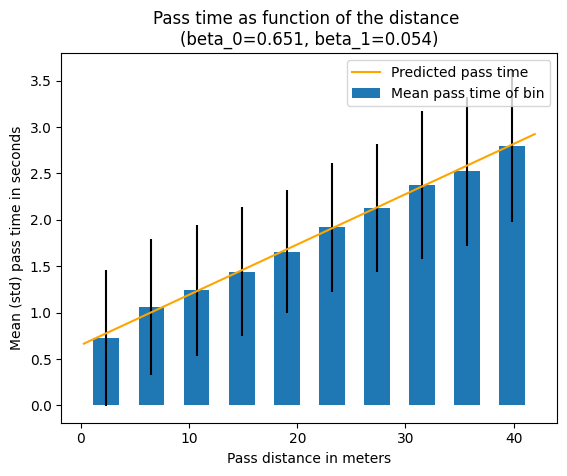

In [21]:
def linear_fit(x, beta_0, beta_1):
    return  beta_0 + (x*beta_1)

# exclude exceptional passes that are too far away
include_idxs = np.where(output_data["pass_distance"] < np.percentile(output_data["pass_distance"], 95))[0]
pass_time = np.array(output_data["pass_time"])[include_idxs]
pass_distance = np.array(output_data["pass_distance"])[include_idxs]

optimal_params, _ = curve_fit(linear_fit, pass_distance, pass_time)
beta_0, beta_1 = optimal_params
fig, ax = create_bins_plot(pass_distance, pass_time, label="Mean pass time of bin")
x_vals = np.linspace(np.min(pass_distance), np.max(pass_distance), 10)
ax.plot(x_vals, [linear_fit(x, beta_0, beta_1) for x in x_vals], label="Predicted pass time", color="orange")
ax.set_xlabel("Pass distance in meters")
ax.set_ylabel("Mean (std) pass time in seconds")
ax.legend()
ax.set_title(f"Pass time as function of the distance \n(beta_0={round(beta_0, 3)}, beta_1={round(beta_1, 3)})")
plt.show()

Although the fit looks good, lets take a moment to think if a linear fit is logical at all. There are roughly two possiblities for this to be possible, first, the ball velocity is constant over the trajectory of the pass, or secondly, the initial velocity of the ball is increasing as the pass distance increases. We know that the ball velocity is not constant over time since the ball must obay the laws of physics and there is resistance on the ball (ball drag) from the grass and the air, so it must be that the start velocities change. Similarly, I think the standard deviations for the pass time for every distance is pretty big. One way to account for this is to take the pass time and add some uncertainty (variance) to the pass time model to account for this standard deviation as the earlier mentioned models have done. However, I think the variance in time travelled of the ball is far from random or an error or even uncertainty. 

I think player intentionally influence the velocity of the ball, and with that the time travelled. For instance, when an attacker gets a pass in front of him, he needs some time to walk towards the end location of the ball, thus the teammate will adjust the speed of the ball to match the time the attacker needs to get to the ball. Similarly, when there are some defenders between the passer and receiver, the passer might increase the ball speed to increase the chance for the ball to reach its teammate without being intercept by the defenders. Therefore, I will not model the time of the ball by a linear approach, rather, I will look at the player locations to determine the optimal pass velocity.

We will do this later on, but we will first focus on modelling the ball speed over time.

From physics we know that the resistance/drag on the ball is relative to the velocity of the ball. The drag force at timepoint $t$ can be defined as: 

$$
F_{drag}(t)=0.5*C*A*P*v(t)^2 
$$

From the work of [Spearman et al.](https://www.researchgate.net/publication/315166647_Physics-Based_Modeling_of_Pass_Probabilities_in_Soccer) we know that the drag coefficient $C$ can be set to a constant of 0.25, the cross-se tional area of a soccer ball $A$ is 0.038 $m^2$, the air density $P$ in normal conditions is about 1.21 $kg/m^3$ and $v(t)$ is the ball velocity in $m/s$ at time $t$ in seconds. Taken together, this will give us:

$$
F_{drag}(t)=0.5*0.25*0.038*1.21*v(t)^2 
$$
$$
F_{drag}(t)=0.0057475*v(t)^2 
$$

To get to the acceleration $a$ of the ball at time $t$ we simply use the laws of Newton:

$$
a_{drag}(t)=\frac{F_{drag}(t)}{m_{ball}}
$$

Where the mass of a ball is about 0.42 kg. Taken together we get the following formula:

$$
a_{drag}(t) = \frac{0.0057475*v(t)^2}{0.42}
$$
$$
a_{drag}(t) = 0.01368452380952381*v(t)^2
$$

Lastly, we can compute the $v(t)$ based on the initial ball velocity $v_{0}$:
$$
v(t)=v_{0}-a_{drag}(t)*t
$$

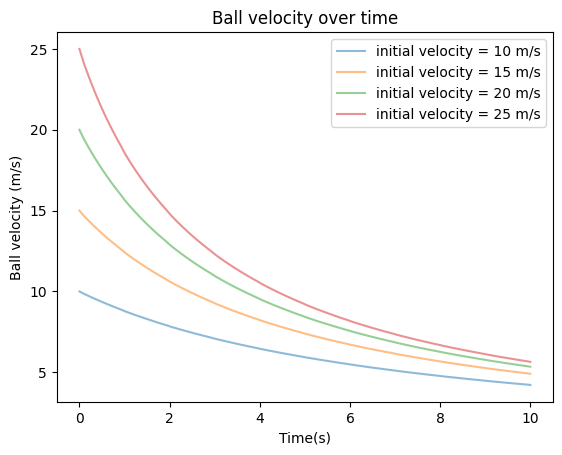

In [4]:
def get_ball_velocity(initial_ball_velocity:float, time:float) -> float:
    """
    Calculate the velocity of a ball based on its initial velocity, time, and decay factor.

    Args:
        initial_ball_velocity (float): velocity of the ball at the start of the pass in m/s
        time (float): the time the ball is underway in seconds.

    Returns:
        float: The calculated velocity of the ball at the given time.
    """
    ball_velocity = initial_ball_velocity
    t = 0
    delta_t=0.01
    while t < time:
        a_drag = 0.01368452380952381 * ball_velocity**2
        ball_velocity -= a_drag*delta_t
        t += delta_t
        
    return ball_velocity

times = np.linspace(0, 10, 100)
fig, ax = plt.subplots()
for initial_velocity in [10, 15, 20, 25]:
    ax.plot(times, [get_ball_velocity(initial_velocity, t) for t in times], label=f"initial velocity = {initial_velocity} m/s", alpha=0.5)
ax.legend()
ax.set_xlabel("Time(s)")
ax.set_ylabel("Ball velocity (m/s)")
ax.set_title("Ball velocity over time")
plt.show()

The graphs look about right. However, there are some major issues if we want to continue with this. Firstly, the loop and `delta_t` make the function really inefficient. Secondly, we are not really interested in the ball velocity over time, but we want to compute the initial ball velocity given that we know the distance covered of the pass and the time it will take the pass, as well as computing the time it takes to get to any location on the ball trajectory. This will help us later to compute the likelyhood of an interception of the ball by a defender. We know that $d(t)=v_{0}*t+0.5*a*t^2$, but this assumes a constant acceleration, that is obviously not the case in our problem. Therefore we need to integrate the formula, but an exact outcome is not possible in this case due to the dependency of the acceleration on the ball velocity. However, we use a different formula to approximate teh ball velocity over time which we can in fact integrate:

$$
v(t) = c_{0} + v_{0}*e^{-c_{1}*(t+c_{2}) + {c_{3}}}
$$

Where $c_{1}$ is the decay factor. We need to optimize this for all different starting velocities and save the optimal parameters.

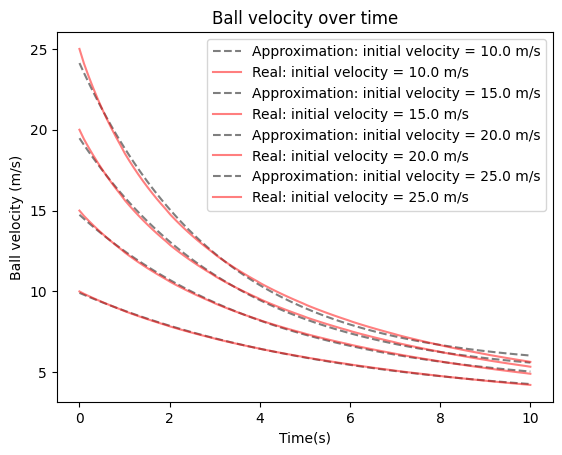

In [5]:
def exponential_decay(X:np.ndarray, c0, c1, c2, c3):
    """
    Exponential decay function.
    
    Args:
        X (array-like): Time values.
        v0 (float): Initial velocity.
        decay_constant (float): Decay constant.
    
    Returns:
        array-like: Decay model values.
    """
    t= X[0]
    v0 = X[1]
    return c0 + v0 * np.exp(-c1*(t+c2) + c3)


optimal_decay_params = {}
loop_initial_velocities = np.linspace(8, 25, (25-8)*10 + 1)
loop_times = np.linspace(0,  10, 100)
for initial_velocity in loop_initial_velocities:
    times = []
    initial_velocities = []
    real_velocities = []
    for t in loop_times:
        times.append(t)
        initial_velocities.append(initial_velocity)
        real_velocities.append(get_ball_velocity(initial_velocity, t))

    X = np.array([times, initial_velocities])
    y = np.array(real_velocities)
    
    # Adding a P0 and bounds based on trial and error to get more stable results
    bounds = ([0, 0, 0.3, -0.8], [13, 1.3, 1.5, -0.])
    optimal_params, _ = curve_fit(exponential_decay, X, y, p0=[X[1, 1]/4., 0.25, 0.4, -0.2], bounds=bounds) 
    c0, c1, c2, c3 = optimal_params
    optimal_decay_params[str(initial_velocity)] = {"c0":c0, "c1":c1, "c2":c2, "c3":c3}

times = np.linspace(0, 10, 100)
fig, ax = plt.subplots()
for initial_velocity in [10., 15.0, 20., 25.0]:
    ax.plot(times, [exponential_decay(np.array([t, initial_velocity]), **optimal_decay_params[str(initial_velocity)]) for t in times], label=f"Approximation: initial velocity = {initial_velocity} m/s", alpha=0.5, linestyle="--", color="black")
    ax.plot(times, [get_ball_velocity(initial_velocity, t) for t in times], label=f"Real: initial velocity = {initial_velocity} m/s", alpha=0.5, color="red")
ax.legend()
ax.set_xlabel("Time(s)")
ax.set_ylabel("Ball velocity (m/s)")
ax.set_title("Ball velocity over time")
plt.show()

Although the approximations are definately not perfect, it is good enough to work with. Now that we have an idea of the ball velocity over time. Lets see if we can derive $V_{0}$ if we know the pass time and the pass distance. Now, we have to get to the formula of the distance over time, instead of the velocity over time. This can be done by taking the integral of the equation:

$$
d(t)=\int v(t)=\int c_{0} + v_{0}*e^{-c_{1}*(t+c_{2}) + {c_{3}}} 
$$
I will not go through the full calculation, but it is equal to:
$$
d(t)=c_{0}*t-v_{0}*e^{c_{3}-c_{1}*(c_{2}+t)}*\frac{1}{c_{1}} + K
$$

For every set of constants we need to solve for $K$ where we know that $d(0)=0$, which simplified leads to:

$$
K = v_{0}*e^{c_{3}-c_{1}*c_{2}}*\frac{1}{c_{1}}
$$

So lets solve that as well for every intial ball velocity:

In [6]:
for initial_velocity in loop_initial_velocities:
    c0, c1, c2, c3 = optimal_decay_params[str(initial_velocity)].values()
    K = initial_velocity * np.exp(c3 - c1 * c2) * (1 / c1)
    optimal_decay_params[str(initial_velocity)]["K"] = K

Now we have the formula for the $d(t)$ and the constant $K$, we can create two new functions. First a function to calculate the right $V_{0}$ given the time of the pass and the distance of the pass:

$$
V_{0} = \frac{-c_{1}dt+c_{0}c_{1}t+c_{1}K}{e^{c_{3}-c_{1}(c_{2}+t)}}
$$

However, there is one more problem; since we do not know the $V_{0}$, we don't know which constants we should put in the formula. This means we have to solve the $d(t)$ for every possible $v_{0}$ and see for which $v_{0}$ the error between known distance and the distance of the result is the lowest, then return that $V_{0}$.

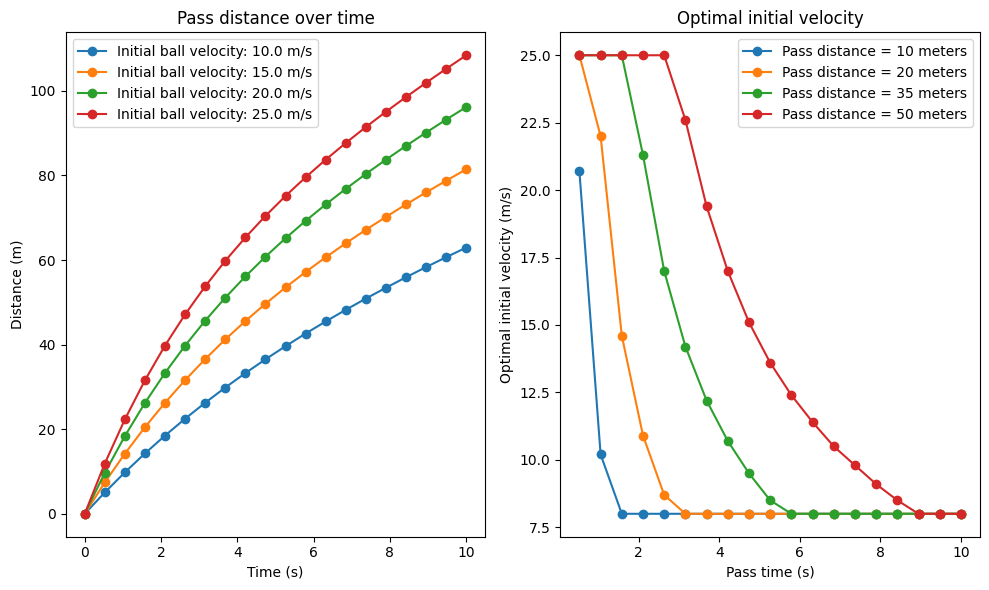

In [7]:
def get_ball_distance_during_pass(initial_velocity: float, time: float, c0: float, c1: float, c2: float, c3: float, K: float) -> float:
    """
    Calculate the distance covered by a ball during a pass given initial conditions.

    Args:
        initial_velocity (float): Initial velocity of the ball.
        time (float): Time of the pass.
        c0 (float): Constant parameter.
        c1 (float): Decay factor.
        c2 (float): Constant parameter.
        c3 (float): Constant parameter.
        K (float): Constant K.

    Returns:
        float: Distance covered by the ball during the pass.
    """
    e_part = np.exp(c3 - c1 * (c2 + time))
    return (c0 * time) - (initial_velocity * e_part) * 1 / c1 + K


def get_initial_ball_velocity(pass_distance: float, pass_time: float, optimal_decay_params: dict = optimal_decay_params, loop_initial_velocities: np.ndarray = loop_initial_velocities) -> float:
    """
    Calculate the initial velocity of a ball during a pass given the desired pass distance and time.

    Args:
        pass_distance (float): Desired distance covered by the pass.
        pass_time (float): Time of the pass.
        optimal_decay_params (dict): Dictionary containing optimal decay parameters.
        loop_initial_velocities (np.ndarray): Array of initial velocities to consider.

    Returns:
        float: Initial velocity of the ball.
    """
    lowest_error = np.inf
    last_v0 = None
    best_idx = None
    for i, current_v0 in enumerate(np.sort(loop_initial_velocities)):
        current_distance = get_ball_distance_during_pass(current_v0, pass_time, **optimal_decay_params[str(current_v0)])
        current_error = np.abs(current_distance - pass_distance)
        if current_error > lowest_error:
            return last_v0
        lowest_error = current_error
        last_v0 = current_v0
        
    return last_v0    

times_xvals = np.linspace(0, 10, 20)
velocities = [10.0, 15.0, 20.0, 25.0]
distances = [10, 20, 35, 50]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

ax1.set_title("Pass distance over time")
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Distance (m)")
for v0 in velocities:
    ax1.plot(times_xvals, [get_ball_distance_during_pass(v0, t, **optimal_decay_params[str(v0)]) for t in times_xvals], marker="o", label=f"Initial ball velocity: {v0} m/s")
ax1.legend()

ax2.set_title("Optimal initial velocity")
ax2.set_xlabel("Pass time (s)")
ax2.set_ylabel("Optimal initial velocity (m/s)")
for distance in distances:
    ax2.plot(times_xvals[1:], [get_initial_ball_velocity(distance, t) for t in times_xvals[1:]], marker="o", label=f"Pass distance = {distance} meters")
ax2.legend()

plt.tight_layout()
plt.show()


Both the pass distance over time and the optimal initial ball velocity plots seem intuitive, which is good news. Of course we have now set the maximal initial ball velocity at 25 m/s (~90 km/h), but I think it is reasonable to assume that passes will not be any faster than that. Similarly, pass initial velocities of lower than 8 m/s are very unlikely. To get the time untill the ball reaches $pos_{k}$ we can now use the following formula, knowing what the actual $v_{0}$ is. However, when deriving this formula, we need to use a Lambert function with uses imaginary numbers. Their are two problems with this approach, firstly, it does not really give stable results, secondly, I have no clue how to calculate this. So due to my lack of knowledge I decided to go for an estimation again.

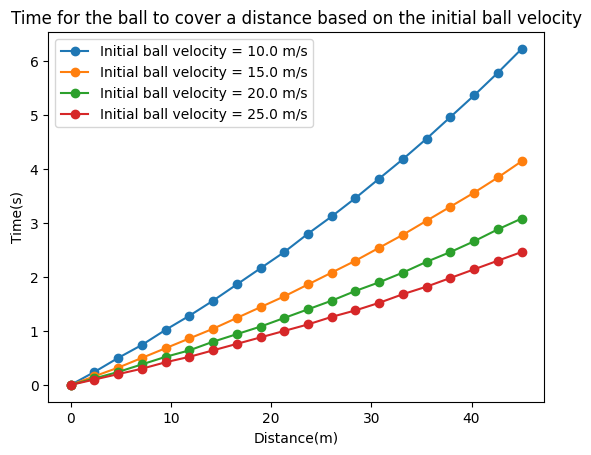

In [8]:
def get_ball_time_to_k(initial_ball_velocity:float, pass_distance:float, optimal_decay_params: dict=optimal_decay_params) -> float:
    """
    Calculate the time for the ball to reach a certain distance during a pass.

    Args:
        initial_ball_velocity (float): Initial velocity of the ball (in meters/second).
        pass_distance (float): Distance covered by the pass (in meters).
        optimal_decay_params (dict, optional): Dictionary containing optimal decay parameters for initial ball velocity.
            Defaults to optimal_decay_params.

    Returns:
        float: Time taken for the ball to reach the specified distance during the pass.

    Notes:
        - This function calculates the time taken for the ball to cover a specific distance during a pass.
        - It iteratively computes the ball's distance at various time points and returns the time when the distance is closest to the specified pass distance.
        - The optimal decay parameters are retrieved from the provided dictionary based on the initial ball velocity.
        - The function returns the time (in seconds) for the ball to reach the specified distance during the pass.
    """
    c0, c1, c2, c3, K = optimal_decay_params[str(initial_ball_velocity)].values()
    last_error = np.inf
    last_t = None
    for t in np.linspace(0, 10, 500):
        distance = get_ball_distance_during_pass(initial_ball_velocity, t, c0, c1, c2, c3, K)
        current_error = np.abs(pass_distance - distance)
        if current_error > last_error:
            return last_t
        last_t = t
        last_error = current_error
    return t

x_vals = np.linspace(0, 45, 20)
fig, ax = plt.subplots()
for initial_velocity in [10.0, 15.0, 20.0, 25.0]:
    ax.plot(x_vals, [get_ball_time_to_k(initial_velocity, x) for x in x_vals], label=f"Initial ball velocity = {initial_velocity} m/s", marker="o")
ax.set_xlabel("Distance(m)")
ax.set_ylabel("Time(s)")
ax.legend()
ax.set_title("Time for the ball to cover a distance based on the initial ball velocity")
plt.show()


## Model 2: Player trajectories over time

For the player models, we do not need to use a drag force, since players continously add in extra force to increase or maintain there speed. However, we do need to model the time $T$ it will take player to get to a certain point on the pitch $pos_{k}$ as a function of their initial position $pos_{0}$ and their initial velocity $v_{0}$. With that, we also need to make some assumptions about the maximal velocity and acceleration of the players. These could be individualized, but for now I will assume that is the same for every player.

For this function we will first calculate the distance that the player has to move to get to $pos_{k}$. Than we use the $v_{0}$ to calculate the velocity in the direction of $pos_{k}$ and compute the time it takes to get to the maximal velocity in the direction of $pos_{k}$. For players that are already moving in the direction of $pos_{k}$ this will be shorter than player that are moving away from $pos_{k}$, even though they are the same $pos_{0}$. The earlier mentioned formula $d(t)= d(t) + v(t)* \Delta t *0.5*a*\Delta t^2$ now applies, because we assume a constant acceleration untill the maximal velocity is reached.

In [22]:
def get_player_time_to_k(pos_k: np.ndarray, pos_0: np.ndarray, vel_0: np.ndarray, max_velocity_players=7.8, max_acceleration_players=3.0) -> float:
    """
    Calculate the time it takes for a player to reach a certain position (k_pos) on the pitch.

    Args:
        pos_k (np.ndarray): Position of point k on the pitch.
        pos_0 (np.ndarray): Initial position of the player.
        vel_0 (np.ndarray): Initial velocity vector of the player.
        maximal_velocity_players (float, optional): Maximum velocity of the player. Defaults to 7.8.
        maximal_acceleration_players (float, optional): Maximum acceleration of the player. Defaults to 3.0.

    Returns:
        float: Time it takes for the player to reach point k.
    """
    initial_distance_to_k = math.dist(pos_0, pos_k)
    initial_speed_along_k = np.dot(vel_0, (pos_k - pos_0)) / initial_distance_to_k
    time_to_max_vel = max(0, (max_velocity_players - initial_speed_along_k) / max_acceleration_players)
    distance_accel = 0.5 * max_acceleration_players * time_to_max_vel**2
    
    if initial_distance_to_k <= distance_accel:
        return np.sqrt(2 * initial_distance_to_k / max_acceleration_players)
    else:
        return time_to_max_vel + (initial_distance_to_k - distance_accel) / max_velocity_players  

def get_loc_shortest_to_ball_trajectory(ball_start_loc: np.ndarray, ball_end_loc: np.ndarray, player_pos: np.ndarray) -> np.ndarray:
    """Find the location on the line segment between ball_start_loc and ball_end_loc closest to player_pos.

    Args:
        ball_start_loc (np.ndarray): The start location of the pass.
        ball_end_loc (np.ndarray): The end location of the pass.
        player_pos (np.ndarray): The position of the player.

    Returns:
        np.ndarray: The location on the pass line closest to the player_pos.
    """

    ball_trajectory_vec = ball_end_loc - ball_start_loc
    player_start_vec = player_pos - ball_start_loc

    scalar_projection = np.dot(player_start_vec, ball_trajectory_vec) / np.dot(ball_trajectory_vec, ball_trajectory_vec)
    t = max(0, min(scalar_projection, 1))
    closest_point = ball_start_loc + t * ball_trajectory_vec

    return closest_point

########################
# def compute_location_over_time(current_position: np.ndarray, end_point: np.ndarray, current_velocity: np.ndarray,
#                                stable_acceleration_magnitude: float, delta_t: float, max_velocity: float) -> tuple:
#     """
#     Computes the location over time given the current position, end point, current velocity vector, stable
#     acceleration magnitude, time step, and maximum velocity.

#     Args:
#         current_position (np.ndarray): The current position of the agent.
#         end_point (np.ndarray): The target end point.
#         current_velocity (np.ndarray): The current velocity vector of the agent.
#         stable_acceleration_magnitude (float): The magnitude of stable acceleration.
#         delta_t (float): The time step.
#         max_velocity (float): The maximum velocity allowed.

#     Returns:
#         tuple: A tuple containing the new position and new velocity vectors of the agent.
#     """
#     direction_to_end_point = end_point - current_position
#     direction_to_end_point /= np.linalg.norm(direction_to_end_point)

#     # Calculate the angle between the current velocity direction and the direction towards the end point
#     cos_theta = np.dot(current_velocity, direction_to_end_point) / (np.linalg.norm(current_velocity) * np.linalg.norm(direction_to_end_point))
#     angle_diff = np.arccos(np.clip(np.abs(cos_theta), -1.0, 1.0)) 

#     # Proportional controller: Adjust acceleration based on angle difference
#     proportional_acceleration = direction_to_end_point * stable_acceleration_magnitude * np.cos(angle_diff) 

#     new_velocity = current_velocity + proportional_acceleration * delta_t
#     norm_velocity = np.linalg.norm(new_velocity)
#     if norm_velocity > max_velocity:
#         new_velocity = (new_velocity / norm_velocity) * max_velocity

#     new_position = current_position + current_velocity * delta_t + 0.5 * proportional_acceleration * delta_t**2

#     return new_position, new_velocity

# def compute_location_over_time(current_position:np.ndarray, end_point:np.ndarray, current_velocity:np.ndarray, stable_acceleration_magnitude:float, delta_t:float, max_velocity:float) -> tuple:
#     """
#     Computes the location over time given the current position, end point, current velocity vector, stable
#     acceleration magnitude, time step, and maximum velocity.

#     Args:
#         current_position (np.ndarray): The current position of the agent.
#         end_point (np.ndarray): The target end point.
#         current_velocity (np.ndarray): The current velocity vector of the agent.
#         stable_acceleration_magnitude (float): The magnitude of stable acceleration.
#         delta_t (float): The time step.
#         max_velocity (float): The maximum velocity allowed.

#     Returns:
#         tuple: A tuple containing the new position and new velocity vectors of the agent.
#     """
#     direction_to_end_point = end_point - current_position
#     direction_to_end_point /= np.linalg.norm(direction_to_end_point)  
#     direction_to_optimal_direction = direction_to_end_point - (current_velocity / np.linalg.norm(current_velocity))
#     direction_to_optimal_direction /= np.linalg.norm(direction_to_optimal_direction)

#     dist = math.dist(current_position, end_point)
#     angle_dir_vel = get_smallest_angle(direction_to_end_point, current_velocity, angle_format="degree")

#     angle_ratio = sigmoid(angle_dir_vel, 1, 0.3, 10, -0.05)
#     dist_ratio = sigmoid(dist, 0.6, -0.15, 25, 0.4)
#     ratio_opt_direction = np.prod((angle_ratio, dist_ratio))

#     acc_direction = ratio_opt_direction * direction_to_optimal_direction + (1-ratio_opt_direction) * direction_to_end_point
#     acc_direction /= np.linalg.norm(acc_direction)
#     acceleration = acc_direction * stable_acceleration_magnitude

#     new_velocity = current_velocity + acceleration * delta_t
#     norm_velocity = np.linalg.norm(new_velocity)
#     if norm_velocity > max_velocity:
#         new_velocity = (new_velocity / norm_velocity) * max_velocity
    
#     new_position = current_position + current_velocity * delta_t + 0.5 * acceleration * delta_t**2.
#     return new_position, new_velocity


################
# def compute_location_over_time(current_position:np.ndarray, end_point:np.ndarray, current_velocity:np.ndarray, stable_acceleration_magnitude:float, delta_t:float, max_velocity:float) -> tuple:
#     """
#     Computes the location over time given the current position, end point, current velocity vector, stable
#     acceleration magnitude, time step, and maximum velocity.

#     Args:
#         current_position (np.ndarray): The current position of the agent.
#         end_point (np.ndarray): The target end point.
#         current_velocity (np.ndarray): The current velocity vector of the agent.
#         stable_acceleration_magnitude (float): The magnitude of stable acceleration.
#         delta_t (float): The time step.
#         max_velocity (float): The maximum velocity allowed.

#     Returns:
#         tuple: A tuple containing the new position and new velocity vectors of the agent.
#     """
#     direction_to_end_point = end_point - current_position
#     direction_to_end_point /= np.linalg.norm(direction_to_end_point)  

#     acceleration = direction_to_end_point * stable_acceleration_magnitude
    

#     new_velocity = current_velocity + acceleration * delta_t
#     norm_velocity = np.linalg.norm(new_velocity)
#     if norm_velocity > max_velocity:
#         new_velocity = (new_velocity / norm_velocity) * max_velocity
    
#     new_position = current_position + current_velocity * delta_t + 0.5 * acceleration * delta_t**2.
    
#     return new_position, new_velocity
    
        
# def get_player_time_to_pass_line(ball_start_loc:np.ndarray, ball_end_loc:np.ndarray, pos_0: np.ndarray, vel_0: np.ndarray, max_velocity_players=7.8, max_acceleration_players=4.0, delta_t=0.05):
#     """
#     Computes the time for a player to pass a line between two points while moving from an initial position and velocity.

#     Args:
#         ball_start_loc (np.ndarray): The starting location of the line segment.
#         ball_end_loc (np.ndarray): The ending location of the line segment.
#         pos_0 (np.ndarray): The initial position of the player.
#         vel_0 (np.ndarray): The initial velocity of the player.
#         max_velocity_players (float, optional): The maximum velocity allowed for the player. Defaults to 7.8.
#         max_acceleration_players (float, optional): The maximum acceleration allowed for the player. Defaults to 3.0.
#         delta_t (float, optional): The time step for computing the player's movement. Defaults to 0.01.

#     Returns:
#         tuple: A tuple containing the time taken by the player to pass the line and an array of positions visited by the player during the movement.
#     """
#     pos = pos_0.copy()
#     vel = vel_0.copy()
#     time = 0
#     positions = [pos]

#     while time < 15.:
#         pos_k = get_loc_shortest_to_ball_trajectory(s_ball, e_ball, pos)
#         pos, vel = compute_location_over_time(pos, pos_k, vel, max_acceleration_players, delta_t, max_velocity_players)
#         positions.append(pos)

#         distance = math.dist(pos_k, pos)
#         if distance < 0.5:
#             ratio = distance / (np.hypot(vel[0], vel[1])*delta_t + max_acc*0.5*delta_t**2.)
#             time += ratio*delta_t
#             positions.append(pos + vel*ratio*delta_t + 0.5 * max_acceleration_players*np.power(ratio*delta_t, 2))
#             return time, np.array(positions)

#         time += delta_t
#         last_distance = distance
#     return time, np.array(positions)

# def get_player_time_to_k(pos_k:np.ndarray, pos_0: np.ndarray, vel_0: np.ndarray, max_velocity_players=7.8, max_acceleration_players=4.0, delta_t=0.05):
#     """
#     Computes the time for a player to reach a point from an initial position and velocity.

#     Args:
#         pos_k (np.ndarray): The point to reach.
#         pos_0 (np.ndarray): The initial position of the player.
#         vel_0 (np.ndarray): The initial velocity of the player.
#         max_velocity_players (float, optional): The maximum velocity allowed for the player. Defaults to 7.8.
#         max_acceleration_players (float, optional): The maximum acceleration allowed for the player. Defaults to 3.0.
#         delta_t (float, optional): The time step for computing the player's movement. Defaults to 0.01.

#     Returns:
#         tuple: A tuple containing the time taken by the player to pass the line and an array of positions visited by the player during the movement.
#     """
#     pos = pos_0.copy()
#     vel = vel_0.copy()
#     time = 0
#     positions = [pos]
#     while time < 15.:
#         pos, vel = compute_location_over_time(pos, pos_k, vel, max_acceleration_players, delta_t, max_velocity_players)
#         positions.append(pos)
#         distance = math.dist(pos_k, pos)
#         if distance < 0.5:
#             ratio = distance / (np.hypot(vel[0], vel[1])*delta_t + max_acc*0.5*delta_t**2.)
#             time += ratio*delta_t
#             positions.append(pos + vel*ratio*delta_t + 0.5 * max_acceleration_players*np.power(ratio*delta_t, 2))
#             return time, np.array(positions)

#         time += delta_t
#         last_distance = distance
#     return time, np.array(positions)



# p0 = np.array([0.1, 0.1])
# p1 = np.array([5.1, .1])
# v0 = np.array([5, -5.])
# new_p, new_v = compute_location_over_time(p0, p1, v0, 3.0, 1., 8.0)
# time, positions= get_player_time_to_pass_line(ball_start_loc, ball_end_loc, p0, v0, defined_pos_k=p1)
# fig, ax = plot_soccer_pitch()
# ax.scatter([p0[0]], [p0[1]], label="P0")
# ax.scatter([p1[0]], [p1[1]], label="P1")
# arrow = mpatches.FancyArrowPatch(p0, p0 + acc, mutation_scale=10, label="acc", facecolor="blue", edgecolor='black', zorder=10)
# ax.add_patch(arrow)
# arrow = mpatches.FancyArrowPatch(p0, p0 + v0, mutation_scale=10, label="vel", facecolor="yellow", edgecolor='black', zorder=10)
# ax.add_patch(arrow)
# ax.plot(positions[:, 0], positions[:, 1])
# ax.legend()
# plt.show()

# print(time)


# pos_0s = np.array([[-2., -12.], [2., -12.], [45., 33.], [-45.,25.]])
# vel_0s = np.array([[-3., 5.], [5., -2.], [-.5, -4.5], [1., -5.]])
# ball_start_loc = np.array([22., 33.])
# ball_end_loc = np.array([-45., 12.])
# colors = ["orange", "red", "blue", "pink"]

# for end_pos in [None, ball_end_loc]:
#     fig, ax = plot_soccer_pitch()
#     arrow = mpatches.FancyArrowPatch(s_ball, e_ball, mutation_scale=7, color="black", label="Pass line")
#     ax.add_patch(arrow)
#     for pos_0, vel_0, c in zip(pos_0s, vel_0s, colors):
#         segment_start_index = 0
#         ax.scatter([pos_0[0]], [pos_0[1]], color=c)
#         arrow = mpatches.FancyArrowPatch(pos_0, pos_0 + vel_0, mutation_scale=10, label="Initial velocity", facecolor=c, edgecolor='black', zorder=10)
#         ax.add_patch(arrow)
#         if end_pos is None:
#             time, positions, = get_player_time_to_pass_line(ball_start_loc, ball_end_loc, pos_0, vel_0)
#         else:
#             time, positions, = get_player_time_to_k(end_pos, pos_0, vel_0)
#         ax.plot(positions[:, 0], positions[:, 1], alpha=0.8, label=f"Time = {round(time, 2)} s", color=c)
#     ax.legend()
#     plt.show()

The last step, before thinking about interception probabilities, is to compute the position where the defenders are most likely to intercept the ball: the location on the pass line where the distance between their position and the pass line is minimal. For that we also create a simple function: 

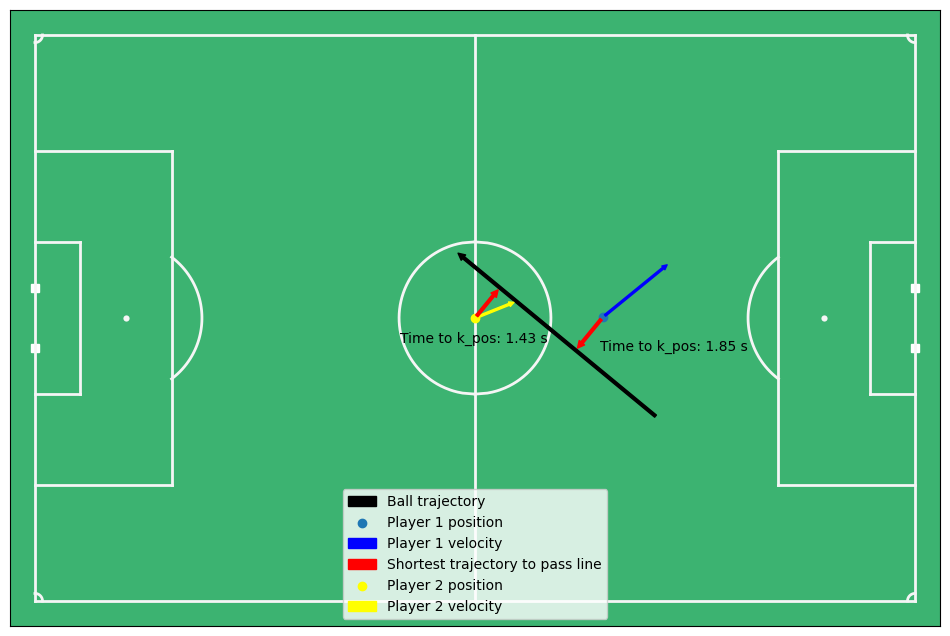

In [23]:
ball_start_loc = np.array([22, -12])
ball_end_loc = np.array([-2.3, 8.])
player_pos = np.array([15.4, 0.1])
player_vel = np.array([8, 6.5])
k_pos = get_loc_shortest_to_ball_trajectory(ball_start_loc, ball_end_loc, player_pos)
time_to_k = get_player_time_to_k(k_pos, player_pos, player_vel)

fig, ax = plot_soccer_pitch()
arrow = mpatches.FancyArrowPatch(ball_start_loc, ball_end_loc, mutation_scale=10, color="black", label="Ball trajectory")
ax.add_patch(arrow)
ax.scatter([player_pos[0]], [player_pos[1]], label="Player 1 position")
arrow = mpatches.FancyArrowPatch(player_pos, player_pos + player_vel, mutation_scale=7, color="blue", label="Player 1 velocity")
ax.add_patch(arrow)
arrow = mpatches.FancyArrowPatch(player_pos, k_pos, mutation_scale=10, color="red", label="Shortest trajectory to pass line")
ax.add_patch(arrow)
ax.text(15, -4, f"Time to k_pos: {round(time_to_k, 2)} s")

player_pos = np.array([0., 0.0])
player_vel = np.array([5, 2.])
k_pos = get_loc_shortest_to_ball_trajectory(ball_start_loc, ball_end_loc, player_pos)
time_to_k = get_player_time_to_k(k_pos, player_pos, player_vel)
ax.scatter([player_pos[0]], [player_pos[1]], label="Player 2 position", color="yellow")
arrow = mpatches.FancyArrowPatch(player_pos, player_pos + player_vel, mutation_scale=7, color="yellow", label="Player 2 velocity")
ax.add_patch(arrow)
arrow = mpatches.FancyArrowPatch(player_pos, k_pos, mutation_scale=10, color="red")
ax.add_patch(arrow)
ax.text(-9, -3, f"Time to k_pos: {round(time_to_k, 2)} s")

ax.legend()
plt.show()


## Model 3: Interception probabilities

Firstly, we will model the probability of an individual player controling the ball, given that the ball travels to the location $pos_{k}$ in $t$ seconds, and the time $T$ it will take the player to get to that same location. The best way to model this probability is using a sigmoid since it always returns a value between 0 and 1. As input of the sigmoid we will give the time difference between the player and the ball to reach $pos_{k}$.

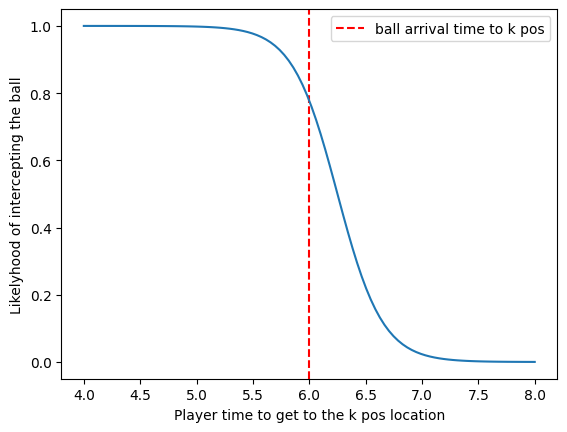

In [24]:
def sigmoid(x:np.ndarray, a:float = 1, b:float = 1, c:float = 0, d:float = 0) -> np.ndarray:
    """Sigmoid function in the shape of a / (1 + e^(-b * (x - c)) ) + d. The defaults 
    are initialized so that the the default function is 1 / (1 + e^(-x)).

    Args:
        x (np.ndarray): Input values.
        a (float, optional): Formula constant. Defaults to 1.
        b (float, optional): Formula constant. Defaults to 1.
        c (float, optional): Formula constant. Defaults to 0.
        d (float, optional): Formula constant. Defaults to 0.

    Returns:
        np.ndarray: Values after passing through the sigmoid. Returned array is
            the same shape as the input shape of x
    """
    return a / (1 + np.exp(-b * (x - c))) + d

def get_interception_probability(ball_time_to_k:float, player_time_to_k) -> float:
    """
    Calculate the interception probability of a ball by a player.

    Args:
        ball_time_to_k (float): Time for the ball to reach the player (seconds).
        player_time_to_k (float): Time for the player to reach the interception point (seconds).

    Returns:
        float: Probability of interception, ranging from 0 to 1.

    Notes:
        - This function calculates the probability of a player intercepting a ball based on the difference
          between the time for the ball to reach the player and the time for the player to reach the interception point.
        - The probability is calculated using the sigmoid function with parameters (1, 5, -0.25, 0), which is defined as:
            sigmoid(x) = 1 / (1 + exp(-(1 * (x - 5) - 0.25 * (x - 5))))
        - The resulting probability ranges from 0 (low probability of interception) to 1 (high probability of interception).
    """
    return sigmoid(ball_time_to_k-player_time_to_k, 1, 5, -0.25, 0)

ball_time = 6.0
player_times = np.linspace(4, 8, 100)
plt.axvline(ball_time, label="ball arrival time to k pos", color='r', linestyle='--')
plt.plot(player_times, [get_interception_probability(ball_time, t) for t in player_times])
plt.xlabel("Player time to get to the k pos location")
plt.ylabel("Likelyhood of intercepting the ball")
plt.legend()
plt.show()

## Model 4: Pass success probability

Now that we know the likelyhood of any player controlling/intercepting the ball, we can start looking at the probability of a successfull pass. For this, different assumptions can be made. For instance [Spearman et al.](https://www.researchgate.net/publication/315166647_Physics-Based_Modeling_of_Pass_Probabilities_in_Soccer) calculates, for any player, all probabilities of intercepting the ball. However, this also assumes that a player can intercept the ball more than once, which doesnt really make sense to me. I like the line of reasoning of [Buldu et al.](http://statsbomb.com/wp-content/uploads/2021/11/Javier-M-Buldu.pdf) and [Everett et al.](https://www.youtube.com/watch?v=sGGyi56Gx2Q) more, as they assume defenders will move to where they are most likely to intercept the ball. However, they take the product of all possible interception probabilities, assuming all defenders will do anything to intercept the ball, this is also an assumption I am not a big fan of. Rather, I would argue that only players that have a certain likelyhood of intercepting the ball will actually try to intercept the ball. This is an arbitrary boundry, but for now we will set this on .25, and assume that tops 3 players will actually move towards the ball to intercept it. There is one more exception we have to talk about, and that is the probability of a high ball, making it impossibel to intercept the ball anywhere on the trajectory but the end location.

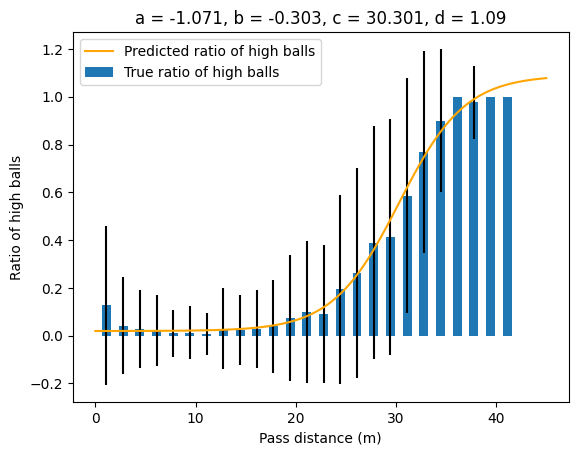

In [28]:
pass_through_air = np.array(output_data["pass_through_air"])[include_idxs]
opt_params, _ = curve_fit(sigmoid, pass_distance, pass_through_air, p0=[-0.86, -0.33, 30.04 ,  0.93])
air_a, air_b, air_c, air_d = opt_params
fig, ax = create_bins_plot(pass_distance, pass_through_air, n_bins=25, label="True ratio of high balls")
x_vals = np.linspace(0, 45, 100)
ax.plot(x_vals, [sigmoid(x, air_a, air_b, air_c, air_d) for x in x_vals], color="orange", label="Predicted ratio of high balls")
ax.set_xlabel("Pass distance (m)")
ax.set_ylabel("Ratio of high balls")
ax.legend(loc="upper left")
ax.set_title(f"a = {round(air_a, 3)}, b = {round(air_b, 3)}, c = {round(air_c, 3)}, d = {round(air_d, 3)}")
plt.show()
def get_pass_through_air_ratio(pass_distance: float, a: float = air_a, b: float = air_b, c: float = air_c, d: float = air_d) -> float:
    """
    Calculate the pass-through-air ratio based on the pass distance.

    Args:
        pass_distance (float): Distance covered by the pass (in meters).
        a (float, optional): Parameter controlling the shape of the sigmoid curve. Defaults to 1.0.
        b (float, optional): Parameter controlling the steepness of the sigmoid curve. Defaults to 0.344.
        c (float, optional): Parameter shifting the curve along the x-axis. Defaults to 29.692.
        d (float, optional): Parameter shifting the curve along the y-axis. Defaults to 0.045.

    Returns:
        float: Pass-through-air ratio, ranging from 0 to 1.

    Notes:
        - This function calculates the pass-through-air ratio based on the sigmoid function applied to the pass distance.
        - The sigmoid function is defined as:
            sigmoid(x) = 1 / (1 + exp(-(a * (x - c) - b * (x - c))))
        - The resulting pass-through-air ratio ranges from 0 (low ratio, indicating more airtime) to 1 (high ratio, indicating less airtime).
        - The default parameters (a, b, c, d) control the shape and positioning of the sigmoid curve, but can be adjusted as needed.
    """
    return np.clip(sigmoid(pass_distance, a, b, c, d), a_min=0.0, a_max=1.0)

That looks like a propper fit. Right now we have to think about how fast players are actually passing. We could assume that players pass the ball at an average velocity and add some uncertainty based on the variation in ball velocities. However, that basically assumes that pass velocity variations are kind of random and non-functional. I think that these variations hold very important information. In fact, I would argue that players try to optimize the likelyhood of a successful pass, one of the variables they can tweak is the initial ball velocity. For instance, when a lot of defenders are closeby, a player may pass the ball with a higher velocity to increase the chance of surpassing those defenders. Similarly, when giving a pass in front of the player, they might pass at a lower velocity, to give the team mate time to reach the ball before it moves outside of the pitch. Following this line of thought, I will assume that the attacker closed to the ball end location is going to claim the ball. If we know how long it takes for the player to get to that position, we can compute the optimal ball start velocity to reach that location at exactly the same time. This way, defenders have less chance to interupt the ball, while the attacker has a high likelyhood of being on time to actually control the ball. This is how we determine the optimal $v_{0}$ for a given pass.

In the samen function, we will deterimen the two attackers that are most likely to claim the ball and the pass end location and compute the probability that either of the two will get the ball. Note that this will always be high since the ball velocity is determined based on when the attackers can arrive at the end location, and the possible interception or claim of a defender is not yet taken into account. We will add this later.

In [30]:
def get_attacker_claim_probability(frame: pd.Series, attacking_column_ids: list, pass_distance: float, pass_end_loc: np.ndarray) -> tuple:
    """
    Calculate the claim probability for the attacking team's player to claim a pass at its end location.

    Args:
        frame (pd.Series): DataFrame row representing a frame of game data.
        attacking_column_ids (list): List of column IDs representing attacking team's players.
        pass_distance (float): Distance covered by the pass (in meters).
        pass_end_loc (np.ndarray): Location where the pass ends (2D array of x and y coordinates).

    Returns:
        tuple: A tuple containing the claim probability, the optimal initial ball velocity, and the
            ball time till to reach the end location of the pass.

    Notes:
        - This function calculates the claim probability for the attacking team's player to intercept a pass.
        - It considers the positions and velocities of the attacking team's players to compute the claim probability.
        - The claim probability is computed based on the shortest time for an attacker to reach the pass end location.
        - The optimal initial ball velocity is computed based on the pass distance and the shortest time for an 
            attacker to reach the end location.
        - The function returns a tuple containing the claim probability and the optimal initial ball velocity.
    """
    pos_0_attackers = np.array([[frame[f"{column_id}_x"], frame[f"{column_id}_y"]] for column_id in attacking_column_ids if not pd.isnull(frame[f"{column_id}_vx"])])
    vel_0_attackers = np.array([[frame[f"{column_id}_vx"], frame[f"{column_id}_vy"]] for column_id in attacking_column_ids if not pd.isnull(frame[f"{column_id}_vx"])])

    if len(vel_0_attackers) == 0:
        return np.nan, np.nan

    distances = np.linalg.norm(pos_0_attackers.astype(np.float64) - pass_end_loc.astype(np.float64), axis=1)
    att_idx = np.argmin(distances)
    att_shortest_time = get_player_time_to_k(
        pos_k=pass_end_loc,
        pos_0=pos_0_attackers[att_idx],
        vel_0=vel_0_attackers[att_idx],
        max_velocity_players=7.8,
        max_acceleration_players=3.0
    )
        

    # Given that we know the attacker time to the end loc, and the pass distance, compute the optimal v_0 of the ball
    optimal_initial_ball_velocity = get_initial_ball_velocity(
        pass_distance,
        att_shortest_time,
        optimal_decay_params=optimal_decay_params,
        loop_initial_velocities=loop_initial_velocities
    )
    ball_time_to_k = get_ball_time_to_k(optimal_initial_ball_velocity, pass_distance)
    # Check for all attackers what their claim probability is
    attacker_claim_probabilities = []
    for pos_0, vel_0 in zip(pos_0_attackers, vel_0_attackers):
        player_time_to_k = get_player_time_to_k(
            pos_k=pass_end_loc,
            pos_0=pos_0,
            vel_0=vel_0,
            max_velocity_players=7.8,
            max_acceleration_players=3.0
        )

        attacker_claim_probabilities.append(
            get_interception_probability(
                ball_time_to_k=ball_time_to_k,
                player_time_to_k=player_time_to_k
            )
        )

    # take the claim probability of the two most likely attackers
    claim_probability = 1 - np.prod(1 - np.sort(attacker_claim_probabilities)[-1:])

    return claim_probability, optimal_initial_ball_velocity, ball_time_to_k


For every defender we can do the same, with the extra information of knowing the $v_{0}$ of the ball. Defenders, however, have two chances to get the ball: first, by intercepting the ball on the way towards the end location, and second, by winning the duel at the end location of the ball. Earlier studies added the interceptition probability of attackers anywhere on the pass line as well, but in my view the end location of the pass changes in that way (as they intercept the ball anywhere on the pass line, not on the pass end location) and therefor is not fair to take into account when you want to compute the likelyhood of a pass being claimed by an attacker at the pass end location. 

In [31]:
def get_defender_claim_and_intercept_probability(frame: pd.Series, defending_column_ids: list, pass_start_loc: np.ndarray, pass_end_loc: np.ndarray, initial_ball_velocity:float, ball_time_to_end:float) -> tuple:
    """
    Calculate defender claim and intercept probabilities for a pass for the defenders.

    Args:
        frame (pd.Series): DataFrame row representing the current frame.
        defending_column_ids (list): List of column IDs representing defending players.
        pass_start_loc (np.ndarray): Starting location of the pass as a NumPy array.
        pass_end_loc (np.ndarray): Ending location of the pass as a NumPy array.
        initial_ball_velocity (float): Initial velocity of the ball (in meters/second).
        ball_time_to_end (float): Time taken for the ball to reach the end location of the pass (in seconds).

    Returns:
        tuple: A tuple containing claim probability and intercept probability.

    Notes:
        - This function calculates the probabilities of defending players claiming and intercepting a pass.
        - It uses player positions and velocities at the current frame along with pass start and end locations.
        - The defender claim probability is computed based on the time for each defender to reach the end location of the pass.
        - The defender intercept probability is computed based on the time for each defender to intercept the ball trajectory between pass start and end locations.
        - The function returns a tuple containing the claim probability and intercept probability.
        - If no defenders are present, NaN values are returned for both probabilities.
    """

    pos_0_defenders = np.array([[frame[f"{column_id}_x"], frame[f"{column_id}_y"]] for column_id in defending_column_ids if not pd.isnull(frame[f"{column_id}_vx"])])
    vel_0_defenders = np.array([[frame[f"{column_id}_vx"], frame[f"{column_id}_vy"]] for column_id in defending_column_ids if not pd.isnull(frame[f"{column_id}_vx"])])
    pass_distance = math.dist(pass_start_loc, pass_end_loc)
    
    if len(vel_0_defenders) == 0:
        return np.nan, np.nan


    defender_intercept_probabilities = []
    defender_claim_probabilities = []
    for pos_0, vel_0 in zip(pos_0_defenders, vel_0_defenders):

        # claim probabilities
        player_time_to_end = get_player_time_to_k(
            pos_k=pass_end_loc,
            pos_0=pos_0,
            vel_0=vel_0,
            max_velocity_players=7.8,
            max_acceleration_players=3.0
        )
        defender_claim_probabilities.append(
            get_interception_probability(
                ball_time_to_k=ball_time_to_end,
                player_time_to_k=player_time_to_end
            )
        )
        
        # intercept probabilities
        pos_k = get_loc_shortest_to_ball_trajectory(pass_start_loc, pass_end_loc, pos_0)
        # if np.all(k_pos == pass_end_loc):
        #     # this is a claim, not a interception
        #     continue
        player_time_to_k = get_player_time_to_k(
            pos_k=pos_k,
            pos_0=pos_0,
            vel_0=vel_0,
            max_velocity_players=7.8,
            max_acceleration_players=3.0
        )
        ball_time_to_k = get_ball_time_to_k(initial_ball_velocity, math.dist(pos_k, pass_start_loc))
        defender_intercept_probabilities.append(
            get_interception_probability(
                ball_time_to_k=ball_time_to_k,
                player_time_to_k=player_time_to_k
            )
        )
    
    # final probability
    claim_probability = 1 - np.prod(1 - np.sort(defender_claim_probabilities)[-2:])
    if len(defender_intercept_probabilities) > 1:
        intercept_probability = 1 - np.prod(1 - np.sort(defender_intercept_probabilities)[-2:])
    elif len(defender_intercept_probabilities) == 1:
        intercept_probability = defender_intercept_probabilities[0]
    else:
        intercept_probability = 0.0
    return claim_probability, intercept_probability


Finally, lets implement the pass success probability by combinin the claim probabilities of both the attackers and defenderns, the probability of a high pass, making it impossible to intercept the ball during the flight time, and the probability of an interception by a defender given that the pass is over the ground.

In [38]:
def get_pass_success_probability(frame:pd.Series, pass_start_loc:np.ndarray, pass_end_loc:np.ndarray, defending_team:str) -> float:
    """
    Calculate the probability of a successful pass.

    Args:
        frame (pd.Series): DataFrame row representing the current frame.
        pass_start_loc (np.ndarray): Starting location of the pass as a NumPy array.
        pass_end_loc (np.ndarray): Ending location of the pass as a NumPy array.
        defending_team (str): The team defending against the pass ('home' or 'away').

    Returns:
        float: The probability of a successful pass.

    Notes:
        - This function calculates the probability of a successful pass based on various factors.
        - It considers the positions of both attacking and defending players, along with pass start and end locations.
        - The defending team's player positions are determined based on the given team label.
        - The function calculates claim and intercept probabilities for both attacking and defending players.
        - It also computes the probability of a high pass through the air, which affects interception likelihood.
        - The final pass success probability is calculated based on a combination of interception probability and player claims.
    """
    attacking_team = "home" if defending_team == "away" else "away"
    defending_column_ids = [x[:-2] for x in frame.index if x.startswith(defending_team) and x.endswith("_x")]
    attacking_column_ids = [x[:-2] for x in frame.index if x.startswith(attacking_team) and x.endswith("_x")]

    pass_distance = math.dist(pass_start_loc, pass_end_loc)
    claim_probability_att, initial_ball_velocity, ball_time_to_end = get_attacker_claim_probability(
        frame=frame, attacking_column_ids=attacking_column_ids, pass_distance=pass_distance, pass_end_loc=pass_end_loc
    )
    claim_probability_def, intercept_probability_def = get_defender_claim_and_intercept_probability(
        frame, defending_column_ids, pass_start_loc, pass_end_loc, initial_ball_velocity, ball_time_to_end
    )

    high_pass_probability = get_pass_through_air_ratio(pass_distance)

    # interception probability
    interception_probability =  intercept_probability_def * (1 - high_pass_probability)

    # if the ball reaches the end pass loc, who will claim the ball
    attacker_wins_claim_probability = sigmoid(claim_probability_att - claim_probability_def, 1, 4, 0, 0)
    
    # return final probability
    return (1 - interception_probability) * attacker_wins_claim_probability
    

## Evaluating the model

Now that we created the model, we will have to look at its results to find out how well it performs and what we need to change. I will evaluate the performance of the model by the accuracy, brier loss, and the confusion matrix. The accuracy will give us a easy explanation of how well the model performs, but it ignores some nuances. The brier loss will give a more clear rating of how sure the model is of its predictions. Lastly, we will also evaluate the confusion matrix to see how the model handles different classes, since about 80% of passes are successful, it is valuable to see how the model handles the minority class.

In [39]:
frames = get_all_pass_info(n=-1)
true_outcomes = []
predicted_outcomes = []
for data in frames:
    frame, pass_start_loc, pass_end_loc, defending_team, true_outcome = data.values()
    success_probability = get_pass_success_probability(frame, pass_start_loc, pass_end_loc, defending_team)
    if pd.isnull(success_probability):
        continue
    predicted_outcomes.append(success_probability)
    true_outcomes.append(true_outcome)

/var/folders/d6/sgv22vx10fb8mj7yrljzpkch0000gn/T/ipykernel_34500/3019068769.py:16: RuntimeWarning: invalid value encountered in scalar divide
  initial_speed_along_k = np.dot(vel_0, (pos_k - pos_0)) / initial_distance_to_k


The current accuracy of the model is 0.816
The current brier loss score is 0.152


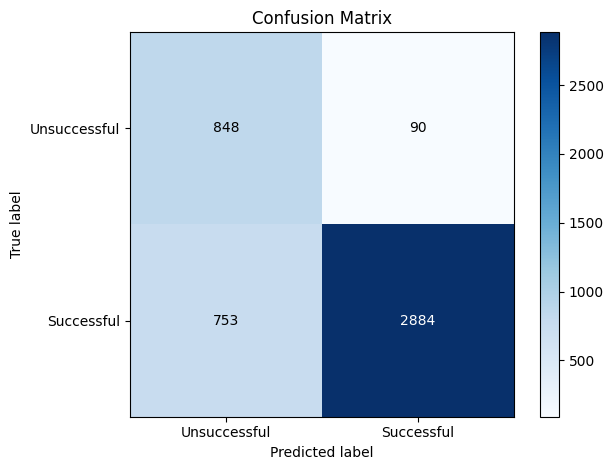

In [40]:
accuracy = accuracy_score(true_outcomes, np.int64(np.array(predicted_outcomes) > 0.5))
brier = brier_score_loss(true_outcomes, predicted_outcomes)
conf_matrix = confusion_matrix(true_outcomes, np.int64(np.array(predicted_outcomes) > 0.5))

def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    """
    Plot the confusion matrix.
    
    Args:
        cm (numpy.ndarray): Confusion matrix.
        classes (list): List of class labels.
        title (str, optional): Title of the plot. Defaults to 'Confusion Matrix'.
    """
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()

plot_confusion_matrix(conf_matrix, ["Unsuccessful", "Successful"])

print(f"The current accuracy of the model is {round(accuracy, 3)}")
print(f"The current brier loss score is {round(brier, 3)}")

The accuracy and the brier loss are pretty good in my opinion. In comparison, the model of [Spearman et al.](https://www.researchgate.net/publication/315166647_Physics-Based_Modeling_of_Pass_Probabilities_in_Soccer) had an accuracy of 82%. Also the brier score is quit low. Sadly, [Buldu et al.](http://statsbomb.com/wp-content/uploads/2021/11/Javier-M-Buldu.pdf) and [Everett et al.](https://www.youtube.com/watch?v=sGGyi56Gx2Q) did not provide any performance metrics on their passing success prediction models. That being said, the confusion matrix raises some serious concerns. If the model predicts a pass to be unsuccessful, the pass in only unsuccessful in 64% of cases. Interestingly, 94% of successful rated passes are also really successful. Later on we will have to find out why the model predicts unsuccessful passes so poorly and if we can do anything about that. 

Lets first look at some visualization to make it more the predictions more tangible.

In [35]:
def plot_frame(frame:pd.Series, pass_start_loc:float, pass_end_loc:float, defending_team:str, grid=None):
    """
    Plot a frame of soccer match with player positions and a pass between two locations.

    Args:
        frame (pd.Series): DataFrame row representing the current frame.
        pass_start_loc (np.ndarray): Starting location of the pass as a NumPy array.
        pass_end_loc (np.ndarray): Ending location of the pass as a NumPy array.
        defending_team (str): The team defending against the pass ('home' or 'away').
        grid (np.ndarray, optional): Grid of pass success probabilities over the pitch. Defaults to None.

    Returns:
        tuple: Figure and Axes objects of the plotted frame.

    Notes:
        - This function plots a single frame of a soccer match with player positions and a pass between two locations.
        - The DataFrame row `frame` should contain information about player positions and velocities.
        - `pass_start_loc` and `pass_end_loc` represent the starting and ending locations of the pass, respectively.
        - Player positions are plotted as scatter points, with different colors representing the home and away teams.
        - Player velocities are visualized as arrows indicating direction and speed.
        - If provided, the `grid` parameter allows overlaying a grid of pass success probabilities on the pitch.
        - Pass success probability grid is visualized using a colormap and a color bar is added to the plot.
    """
    fig, ax = plot_soccer_pitch(pitch_color="white", field_dimen=(106, 68))
    ax.scatter(frame["ball_x"], frame["ball_y"], color="black")
    arrow = mpatches.FancyArrowPatch(
        pass_start_loc,
        pass_end_loc,
        mutation_scale=10,
        color="black",
    )
    ax.add_patch(arrow)

    home_column_ids = [x[:-2] for x in frame.index if x.startswith("home") and x.endswith("_x")]
    away_column_ids = [x[:-2] for x in frame.index if x.startswith("away") and x.endswith("_x")]
    x_home = frame[[x + "_x" for x in home_column_ids]].values
    y_home = frame[[y + "_y" for y in home_column_ids]].values
    vx_home = frame[[x + "_vx" for x in home_column_ids]].values
    vy_home = frame[[y + "_vy" for y in home_column_ids]].values
    x_away = frame[[x + "_x" for x in away_column_ids]].values
    y_away = frame[[y + "_y" for y in away_column_ids]].values
    vx_away = frame[[x + "_vx" for x in away_column_ids]].values
    vy_away = frame[[y + "_vy" for y in away_column_ids]].values
    if defending_team == "home":
        colors = ["blue", "red"]
    else:
        colors = ["red", "blue"]
    ax.scatter(x_home, y_home, color=colors[0])
    ax.scatter(x_away, y_away, color=colors[1])

    for x, y, vx, vy in zip(x_home, y_home, vx_home, vy_home):
        if pd.isnull(vx):
            continue
        arrow = mpatches.FancyArrowPatch(
            (x, y),
            (x + vx, y + vy),
            mutation_scale=7
        )

        ax.add_patch(arrow)

    for x, y, vx, vy in zip(x_away, y_away, vx_away, vy_away):
        if pd.isnull(vx):
            continue
        arrow = mpatches.FancyArrowPatch(
            (x, y),
            (x + vx, y + vy),
            mutation_scale=7
        )
        ax.add_patch(arrow)

    if grid is not None:
        imshow = ax.imshow(grid.T, extent=[-53, 53, -34, 34], cmap="coolwarm", alpha=0.7, vmin=0, vmax=1, origin='upper', aspect='auto')
        plt.colorbar(imshow, label='Pass success probability')
    return fig, ax

def get_pass_success_probability_grid(frame:pd.Series, pass_start_loc:np.ndarray, defending_team:str, grid_shape:tuple=(64, 48)) -> np.ndarray:
    """
    Calculate the pass success probability grid over a specified grid shape.

    Args:
        frame (pd.Series): DataFrame row representing the current frame.
        pass_start_loc (np.ndarray): Starting location of the pass as a NumPy array.
        defending_team (str): The team defending against the pass ('home' or 'away').
        grid_shape (tuple, optional): Shape of the grid for calculating pass success probabilities. Defaults to (128, 96).

    Returns:
        np.ndarray: Grid of pass success probabilities over the specified grid shape.

    Notes:
        - This function calculates a grid of pass success probabilities over a specified grid shape.
        - The grid covers a rectangular area defined by the provided grid shape.
        - Pass success probabilities are computed for each grid cell based on the given frame and pass start location.
        - The defending team's positions are determined based on the given team label.
        - The resulting grid provides a spatial distribution of pass success probabilities across the defined area.
    """
    grid = np.zeros(grid_shape)
    x_ranges = np.linspace(-53, 53, grid_shape[0] + 1)
    y_ranges = np.linspace(34, -34, grid_shape[1] + 1)

    for i, x in enumerate((x_ranges[:-1] + x_ranges[1:]) / 2):
        for j, y in enumerate((y_ranges[:-1] + y_ranges[1:]) / 2):
            grid[i, j] = get_pass_success_probability(frame, pass_start_loc, np.array([x, y]), defending_team)

    return grid

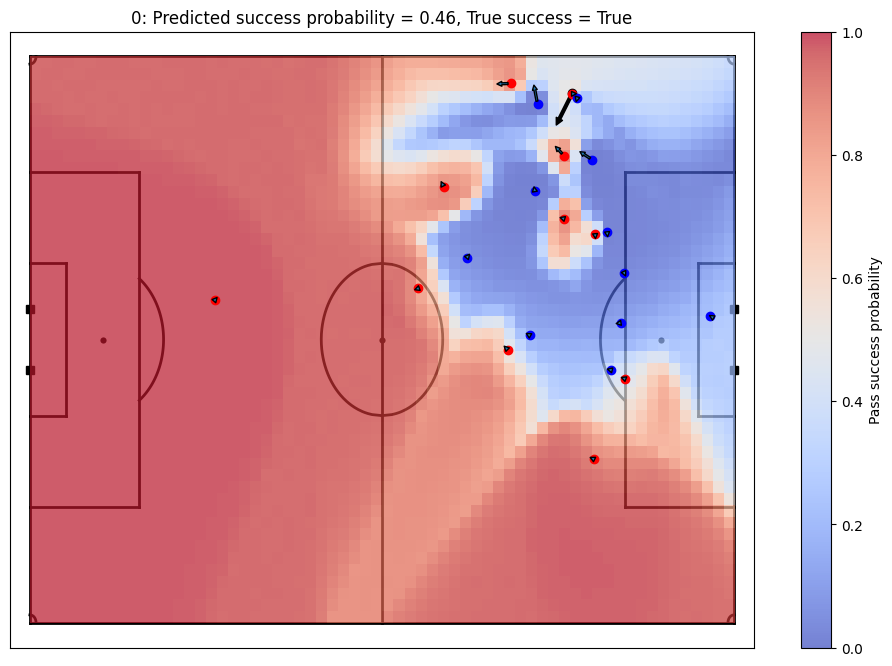

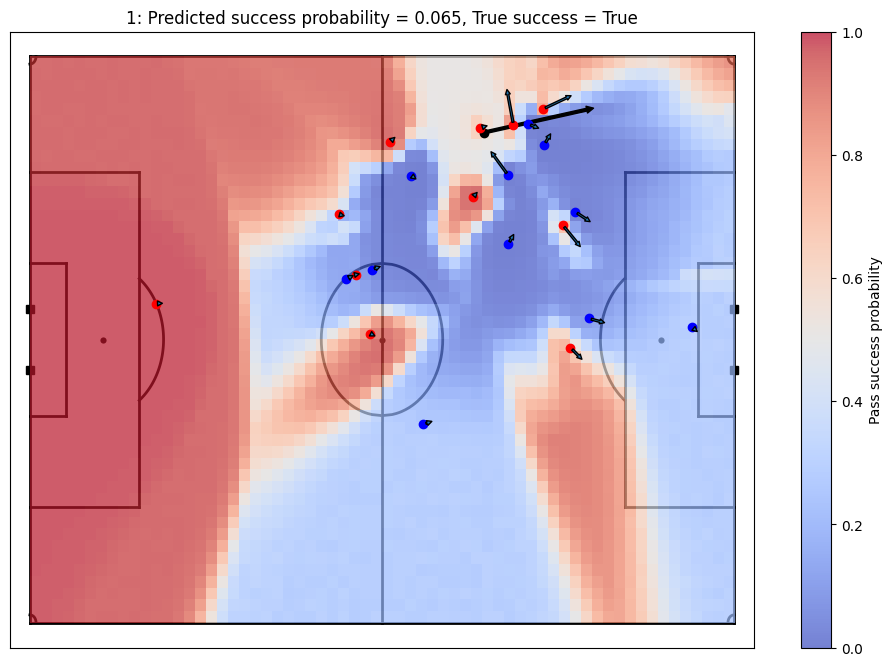

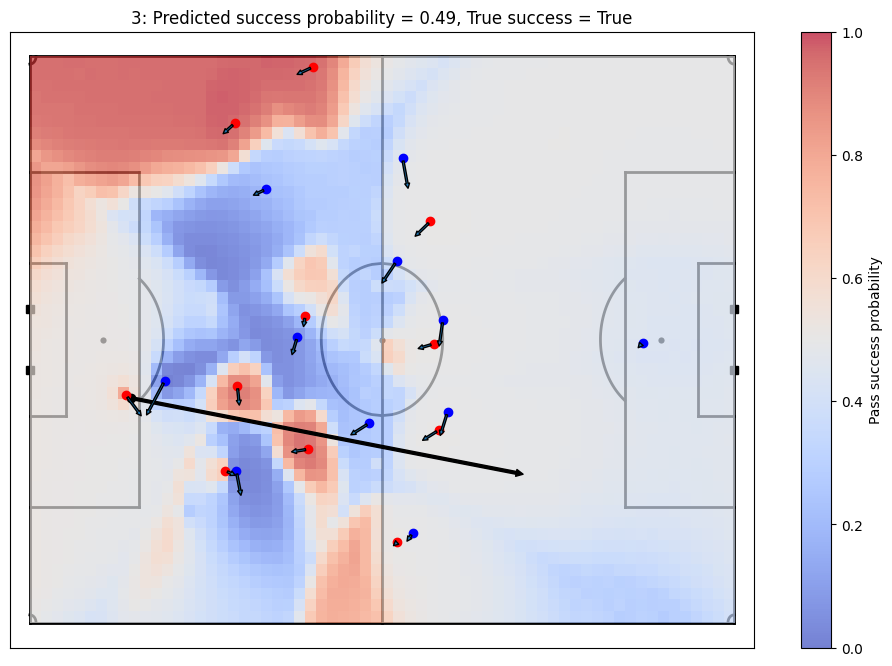

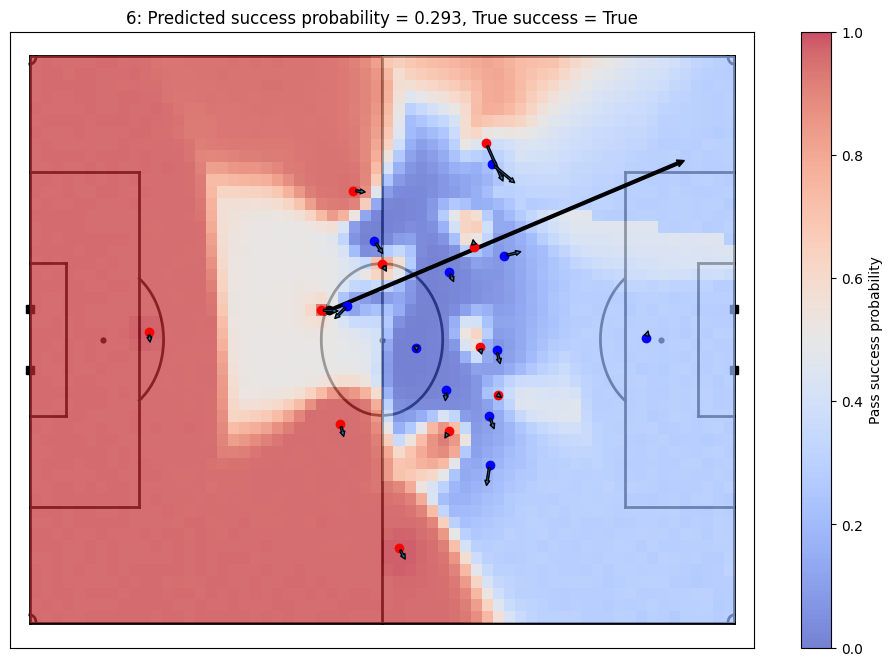

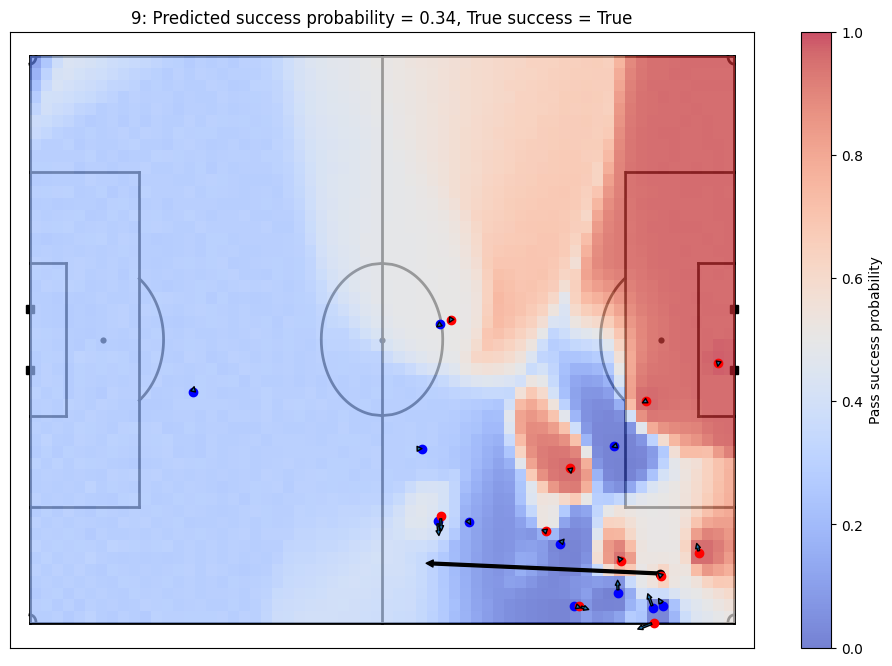

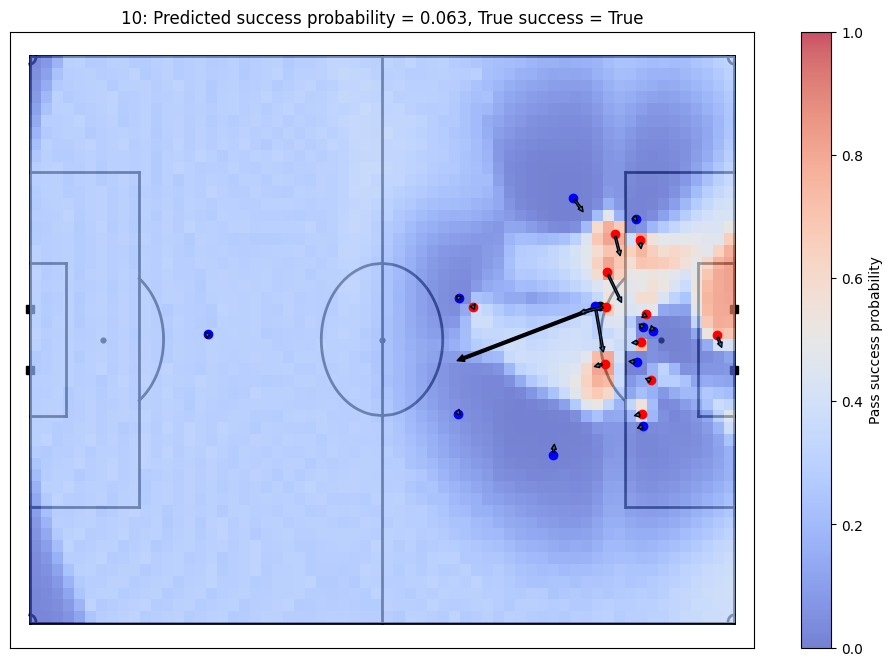

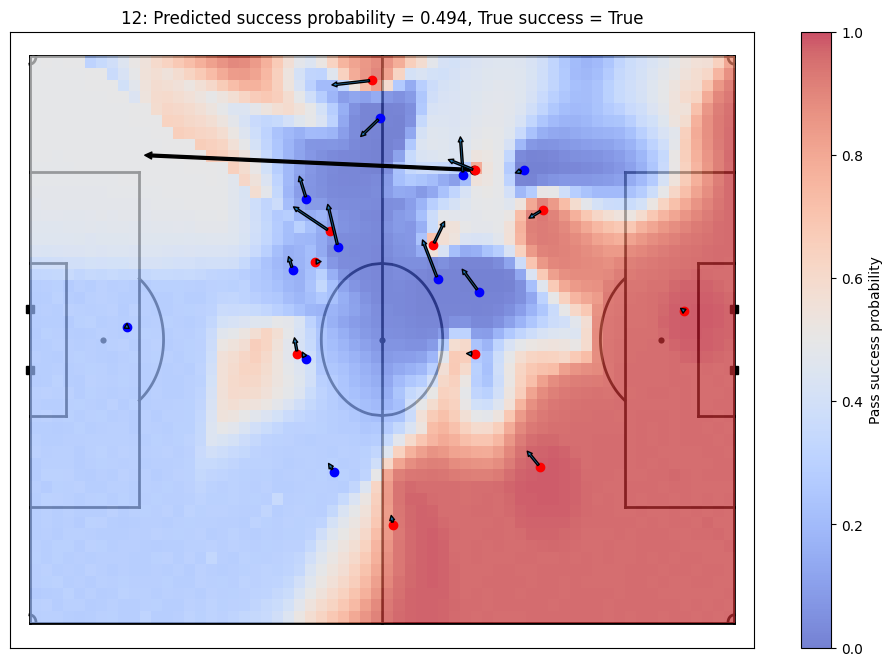

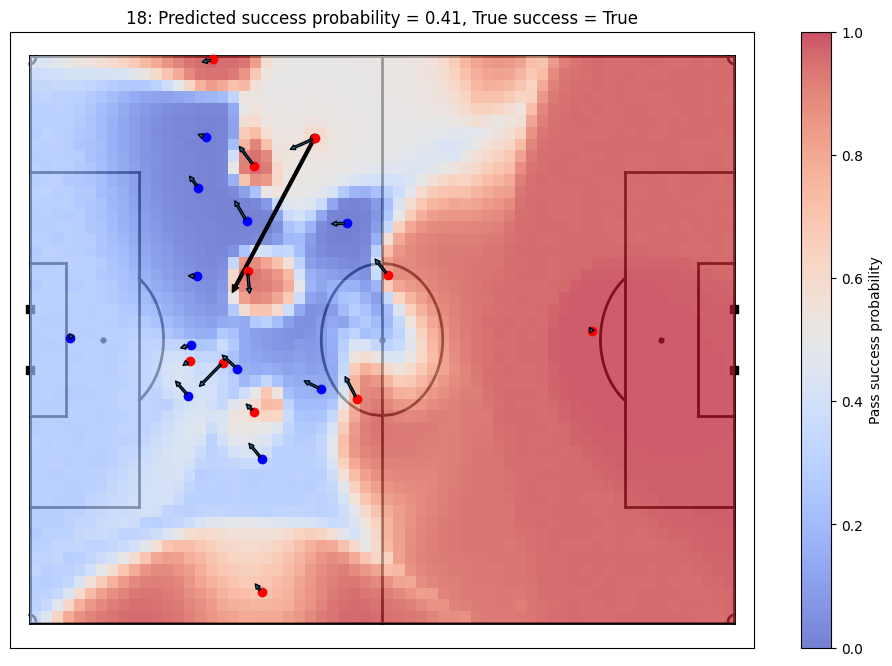

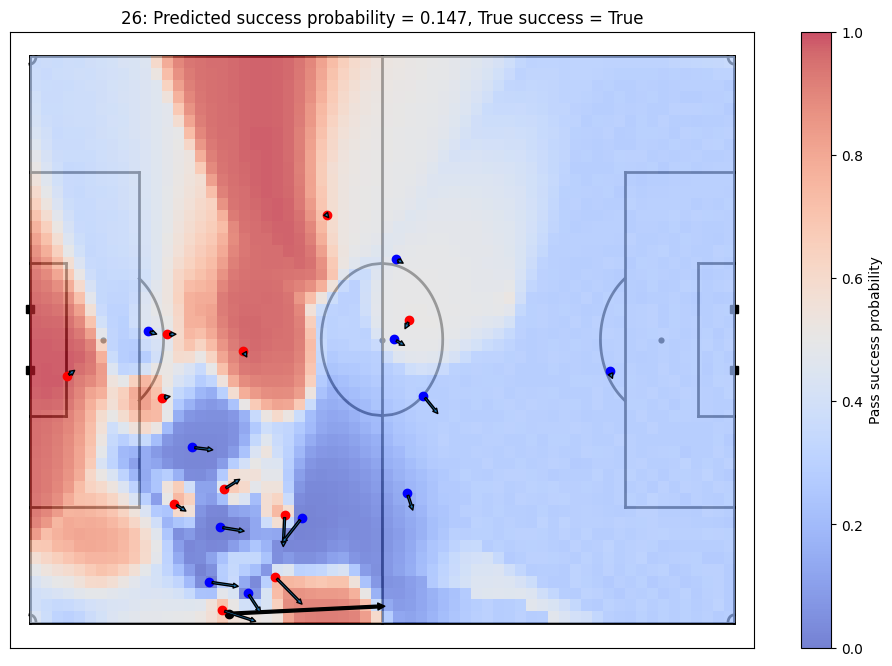

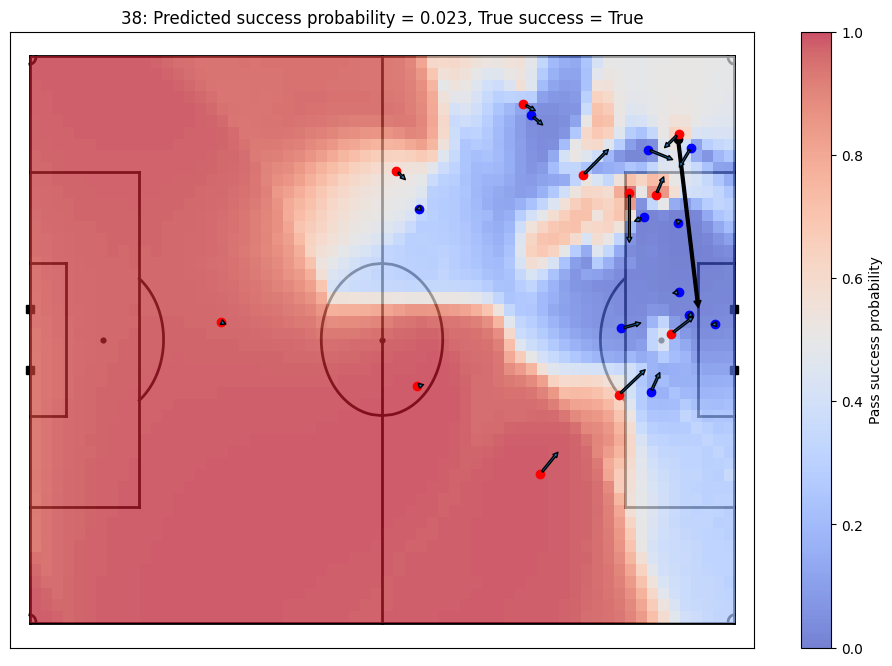

In [37]:
random.shuffle(frames)
counts = 0
for i, data in enumerate(frames):
    frame, pass_start_loc, pass_end_loc, defending_team, true_success = data.values()
    # pass_try_end = np.array([30, 14])
    success_probability = get_pass_success_probability(frame, pass_start_loc, pass_end_loc, defending_team)
    if success_probability < 0.5 and true_success == 1:
        grid = get_pass_success_probability_grid(frame, pass_start_loc, defending_team, grid_shape=(64, 48))
        fig, ax = plot_frame(frame, pass_start_loc, pass_end_loc, defending_team, grid=grid)
        ax.set_title(f"{i}: Predicted success probability = {round(success_probability, 3)}, True success = {bool(true_success)}")
        plt.show()
        counts += 1
    if counts >= 10:
        break


In [48]:
pass_start_loc

array([17.136     , 10.65771429])

In [695]:
3192/(221+3192)

0.935247582771755